# Rangelands dynamics with Sentinel-1

This notebook gives an example of using Sentinel-1 analysis ready data (ARD) radar backscatter (Gamma nought) and dual-polarimetric decomposition (Alpha, Entropy and Anisotropy) for exploring annual rangeland dynamics.

Sentinel-1 (in this case it is the dual-pol Radar Vegetation Index (RVI) and Entropy bands) and Sentinel-2 NDVI are compared for multitemporal trends due to their relationships with vegetation biomass. A grasslands mask (read in as a shape file) is then applied to extract only the areas of interest, before the monthly means are generated for the RVI and Entropy bands. These monthly means as well as the annual range in RVI and Entropy are then output as GeoTIFF files.

The following steps are used:
1.  Load Sentinel-1 radar backscatter data through the datacube API
2.  Apply speckle filtering
3.  Calculate the dual-pol Radar Vegetation Index (RVI)
4.  Load Sentinel-1 dual-pol decomposition data
5.  Load Sentinel-2 data and calculate NDVI
6.  Interactively compare RVI, Entropy and NDVI time series
7.  Show annual statistics
8.  Generate monthly means
9.  Save results to GeoTIFF files

This notebook was written using the Virtual Desktop Infrastructure (VDI) on the National Computational Infrastructure (NCI), allowing access to the current Sentinel-1 and Digitial Earth Australia (DEA) ARD datasets. For this notebook to work you must first load the relevant modules:
-  module use /g/data/v10/public/modules/modulefiles
-  module load dea

# 1. Load Sentinel-1 radar backscatter data through the datacube API

Area of interest is in the Fitzroy Catchment of Western Australia

In [11]:
# Import relevant modules for this Jupyter Notebook and start datacube

import datacube
import numpy as np
import xarray as xr
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from matplotlib import pyplot as plt
from IPython.display import display
from IPython.display import HTML
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore', module='datacube')

dc = datacube.Datacube(env='datacube')#, config='radar.conf')

In [ ]:
# run this cell to hide all code within notebook

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Select area of interest for year of interest 
>  Currently only use 2017 or 2018 for full years <br>
>  Note that the area of interest must be small to avoid memory issues

In [2]:
import ipywidgets as widgets
from ipywidgets import interact
#from matplotlib import pyplot as plt
import matplotlib.image as mplImage

In [3]:
dc.list_products()

name                                        description  \
id                                                                              
5        ls5_usgs_sr_scene  Landsat 5 USGS Collection 1 Level2 Surface Ref...   
4        ls7_usgs_sr_scene  Landsat 7 USGS Collection 1 Level2 Surface Ref...   
3           ls8_usgs_scene                        Landsat 8 USGS Collection 1   
1       modis_mcd43a4_tile             MODIS 500 metre MCD43A4 Collection 006   
2       modis_mod13q1_tile  MODIS Terra Vegetation Indices 16-Day Global 2...   
10     s1a_grd_wgs84_scene                                 Sentinel-1 SAR GRD   
8   s1_decomposition_scene  Sentinel-1A/B decomposition. Processed as deta...   
6       s1_intensity_scene  Sentinel-1A/B intensity. Processed as detailed...   
7             s2_l1c_scene                                     Sentinel-2 L1C   
9             s2_l2a_scene                                     Sentinel-2 L2A   

   creation_time label instrument  time   format     platform   lat   lon  \
id                                                                          
5           None  None         TM  None  GeoTiff    LANDSAT_5  None  None   
4           None  None        ETM  None  GeoTiff    LANDSAT_7  None  None   
3           None  None   OLI_TIRS  None  GeoTiff    LANDSAT_8  None  None   
1           None  None      MODIS  None  GeoTiff   AQUA_TERRA  None  None   
2           None  None      MODIS  None  GeoTiff   AQUA_TERRA  None  None   
10          None  None      C-SAR  None  GeoTiff  SENTINEL_1A  None  None   
8           None  None        SAR  None     ENVI   SENTINEL_1  None  None   
6           None  None        SAR  None     ENVI   SENTINEL_1  None  None   
7           None  None      C-SAR  None  GeoTiff  SENTINEL_2A  None  None   
9           None  None      C-SAR  None  GeoTiff  SENTINEL_2A  None  None   

        product_type                                                crs  \
id                                                                        
5             LEDAPS                                                NaN   
4             LEDAPS                                                NaN   
3       LPGS / LaSRC                                                NaN   
1        MCD43A4.006  PROJCS["unnamed",GEOGCS["Unknown datum based u...   
2        MOD13Q1.006                                          EPSG:4326   
10               GRD                                          EPSG:4326   
8   s1_decomposition                                          EPSG:4326   
6       s1_intensity                                          EPSG:4326   
7             MSIL1C  PROJCS["WGS 84 / UTM zone 50S",GEOGCS["WGS 84"...   
9             MSIL2A  PROJCS["WGS 84 / UTM zone 56S",GEOGCS["WGS 84"...   

                               resolution  tile_size     spatial_dimensions  
id                                                                           
5                                     NaN        NaN                    NaN  
4                                     NaN        NaN                    NaN  
3                                     NaN        NaN                    NaN  
1   (-463.312716527778, 463.312716527778)        NaN                 (y, x)  
2                       (-0.0025, 0.0025)        NaN  (latitude, longitude)  
10                      (-0.0001, 0.0001)        NaN  (latitude, longitude)  
8                       (-0.0002, 0.0002)        NaN  (latitude, longitude)  
6                       (-0.0002, 0.0002)        NaN  (latitude, longitude)  
7                           (-10.0, 10.0)        NaN                 (y, x)  
9                                    None        NaN                 (y, x)

In [4]:
dc.list_measurements()

name  dtype        units  nodata  \
product           measurement                                           
ls5_usgs_sr_scene blue               blue  int16  reflectance   -9999   
                  green             green  int16  reflectance   -9999   
                  red                 red  int16  reflectance   -9999   
                  nir                 nir  int16  reflectance   -9999   
                  swir1             swir1  int16  reflectance   -9999   
...                                   ...    ...          ...     ...   
s2_l2a_scene      WVP_60m         WVP_60m  uint8            1       0   
                  CLDPRB_20m   CLDPRB_20m  uint8            1       0   
                  CLDPRB_60m   CLDPRB_60m  uint8            1       0   
                  SNWPRB_20m   SNWPRB_20m  uint8            1       0   
                  SNWPRB_60m   SNWPRB_60m  uint8            1       0   

                                          aliases flags_definition  
product           measurement                                       
ls5_usgs_sr_scene blue         [band_1, sr_band1]              NaN  
                  green        [band_2, sr_band2]              NaN  
                  red          [band_3, sr_band3]              NaN  
                  nir          [band_4, sr_band4]              NaN  
                  swir1        [band_5, sr_band5]              NaN  
...                                           ...              ...  
s2_l2a_scene      WVP_60m                     NaN              NaN  
                  CLDPRB_20m                  NaN              NaN  
                  CLDPRB_60m                  NaN              NaN  
                  SNWPRB_20m                  NaN              NaN  
                  SNWPRB_60m                  NaN              NaN  

[127 rows x 6 columns]

In [ ]:
image = mplImage.imread('/g/data/qd04/Cate/TempProcessing/LocImage.png')
plt.imshow(image)

In [ ]:
@interact(mysite=['Site1','Site2'])

def plot(mysite='Site1'):
    global latn, lats, lonw, lone, myloc
    if mysite == 'Site1': lats, latn, lonw, lone, myloc = -18.6, -18.4, 125.0, 125.2, 'Site1'
    if mysite == 'Site2': lats, latn, lonw, lone, myloc = -18.8, -18.6, 125.5, 125.7, 'Site2'

In [ ]:
# Select Year

@interact(myyear=['2017','2018'])

def plot(myyear='2017'):
    global yearSel
    if myyear == '2017': yearSel = '2017'
    if myyear == '2018': yearSel = '2018'
        
# Define area of interest and year within a query

Year = yearSel

query = {

'y': (lats, latn),
'x': (lonw, lone),
    
'time': (Year + '-01-01', Year + '-12-31'),
'crs': 'EPSG:4326',
'output_crs': 'EPSG: 3577',
'resolution': (25, -25)
}

In [67]:
Year = '2019'
myloc = 'ACT'
query = {
#x=(149.05, 149.17), y=(-35.25, -35.35),
# Canberra
#'y': (-35.35, -35.25),
#'x': (149.05, 149.17),
    
# Lake George
'y': (-35.15, -35.25),
'x': (149.35, 149.45),
    
#'time': (Year + '-05-01', Year + '-06-05'),
'time': (Year + '-01-01', Year + '-10-01'),
'crs': 'EPSG:4326',
'output_crs': 'EPSG: 3577',
'resolution': (25, -25)
}

# Read radar backscatter, clean and smooth data

In [68]:
bs=dc.load(product='s1_intensity_scene', group_by='solar_day', **query)

# Identify images that have minimum nulls
# Uses code from https://github.com/fangfy/dea-projects/blob/master/water_interoperability/sentinel1_load_and_classify_nci.ipynb

total_px=len(bs.x)*len(bs.y)
valid=bs.where(bs.vv!=0).where(bs.vh!=0).count(dim=('x','y'))

good=(valid.vh/total_px)>0.5

bs_good = bs.sel(time=good)
# replace 0 with nan
bs_clean = bs_good.where(bs_good!=0)

# Adapted from https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance

def lee_filter(da, size):
    img = da.values
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

# save the nodata mask
nodata_mask = bs_clean.isnull().to_array().any(axis=0)
# Convert backscatter nans to 0 for lee filter
bs_good_zerofilled = bs_good.where(~bs_good.isnull(), 0)

# Apply speckle filter
smoothed_vv=bs_good_zerofilled.vv.groupby('time').apply(lee_filter, size=7)
smoothed_vh=bs_good_zerofilled.vh.groupby('time').apply(lee_filter, size=7)

# Create smoothed dataset with Nans and assign attributes
smoothed=smoothed_vv.to_dataset(name='vv')
smoothed['vh']=smoothed_vh
smoothed=smoothed.where(~nodata_mask)

# Remove unused data
bs_attrs = bs.attrs
smoothed = smoothed.assign_attrs(bs_attrs)

del bs, bs_good, bs_clean
print('Backscatter data for ', myloc,': ',smoothed)

Backscatter data for  ACT :  <xarray.Dataset>
Dimensions:  (time: 21, x: 422, y: 491)
Coordinates:
  * y        (y) float64 -3.958e+06 -3.958e+06 ... -3.946e+06 -3.946e+06
  * x        (x) float64 1.581e+06 1.581e+06 1.581e+06 ... 1.571e+06 1.571e+06
  * time     (time) datetime64[ns] 2019-01-10T19:16:20.913148 ... 2019-10-01T19:16:29.607313
Data variables:
    vv       (time, y, x) float32 0.04620899 0.04637416 ... 0.052153107
    vh       (time, y, x) float32 0.012287186 0.012401758 ... 0.011741415
Attributes:
    crs:      EPSG: 3577


## View smoothed images (VV or VH)

In [69]:
# View smoothed data (Note - you might need to edit 'figsize' to improve appearance)

ntimes=len(smoothed.time.values)

@interact(mypol=['VV','VH'])

def plot(mypol='VV'):
    if mypol == 'VV': smoothed.vv.isel(time=slice(0,ntimes,4)).plot(col='time',col_wrap=4, vmin=0, vmax=0.4);
    if mypol == 'VH': smoothed.vh.isel(time=slice(0,ntimes,4)).plot(col='time',col_wrap=4, vmin=0, vmax=0.08);


interactive(children=(Dropdown(description='mypol', options=('VV', 'VH'), value='VV'), Output()), _dom_classes…

## Calculate and view modified dual-pol Radar Vegetation Index images

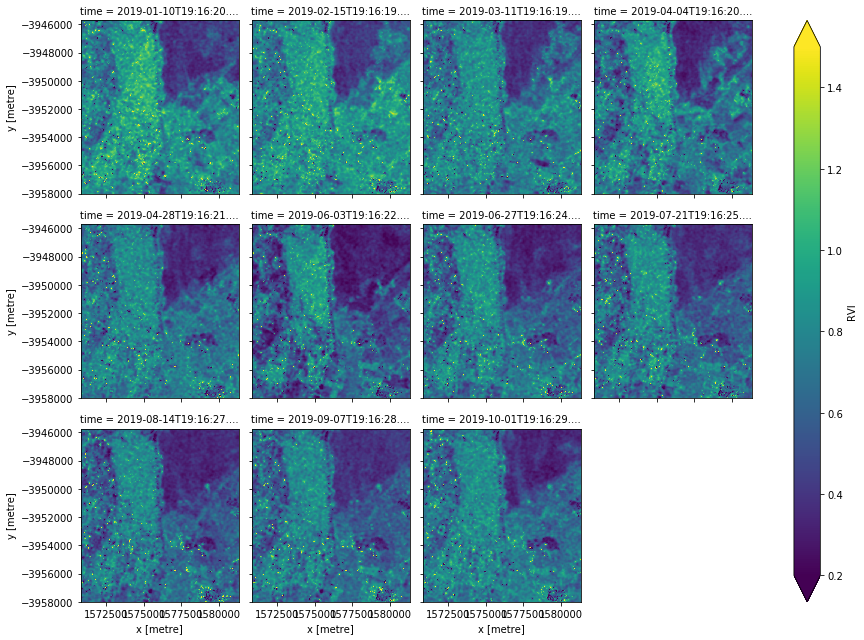

In [71]:
# View RVI data

smoothed['RVI'] = 4*smoothed.vh/(smoothed.vv + smoothed.vh)

ntimes=len(smoothed.time.values)
smoothed.RVI.isel(time=slice(0,ntimes,2)).plot(col='time',col_wrap=4, vmin=0.2, vmax=1.5);

# Read in dual-pol decomposition data
## This results in Alpha, Anisotropy and Entropy bands

In [72]:
dp=dc.load(product='s1_decomposition_scene', group_by='solar_day', **query)

dp = dp.where(dp.entropy!=0)
print('Dual polarimetric decomposition data for ', myloc,': ',dp)

Dual polarimetric decomposition data for  ACT :  <xarray.Dataset>
Dimensions:     (time: 44, x: 422, y: 491)
Coordinates:
  * time        (time) datetime64[ns] 2019-01-03T19:24:14.578597 ... 2019-10-01T19:16:29.460268
  * y           (y) float64 -3.958e+06 -3.958e+06 ... -3.946e+06 -3.946e+06
  * x           (x) float64 1.581e+06 1.581e+06 ... 1.571e+06 1.571e+06
Data variables:
    alpha       (time, y, x) float32 nan nan nan ... 69.235634 66.987816
    anisotropy  (time, y, x) float32 nan nan nan ... 0.5941013 0.5158832
    entropy     (time, y, x) float32 nan nan nan ... 0.726584 0.7915737
Attributes:
    crs:      EPSG: 3577


In [75]:
# Identify images that have minimum nulls
# Uses code from https://github.com/fangfy/dea-projects/blob/master/water_interoperability/sentinel1_load_and_classify_nci.ipynb

total_px=len(dp.x)*len(dp.y)
valid=dp.where(dp.entropy!=0).where(dp.anisotropy!=0).count(dim=('x','y'))

good=(valid.dp/total_px)>0.5

dp = dp.sel(time=good)
# replace 0 with nan
dp = dp.where(dp!=0)

AttributeError: 'Dataset' object has no attribute 'dp'

## View Alpha or Entropy images

In [73]:
ntimes=len(dp.time.values)

# View entropy (values range from 0-1.0) data 
# (can also change to look at 'anisotropy' (values ~0-1.0))

@interact(mypol=['Alpha','Entropy'])

def plot(mypol='Entropy'):
    if mypol == 'Alpha': dp.alpha.isel(time=slice(0,ntimes,4)).plot(col='time',col_wrap=4, vmin=40, vmax=80.0);
    if mypol == 'Entropy': dp.entropy.isel(time=slice(0,ntimes,4)).plot(col='time',col_wrap=4, vmin=0, vmax=1.0);


interactive(children=(Dropdown(description='mypol', index=1, options=('Alpha', 'Entropy'), value='Entropy'), O…

# Load Sentinel-2 to extract NDVI time series

In [76]:
dc_S2 = datacube.Datacube(app='s2a_scene')
bands_of_interest = ['B04_20m', 'B03_20m', 'B02_20m', 'B08_10m','SCL_20m']
s2_data = dc_S2.load(product = 's2_l2a_scene', group_by='solar_day', measurements = bands_of_interest, **query)
s2_data

<xarray.Dataset>
Dimensions:  (time: 50, x: 422, y: 491)
Coordinates:
  * time     (time) datetime64[ns] 2019-01-05T00:02:41 ... 2019-09-27T00:02:39
  * y        (y) float64 -3.958e+06 -3.958e+06 ... -3.946e+06 -3.946e+06
  * x        (x) float64 1.581e+06 1.581e+06 1.581e+06 ... 1.571e+06 1.571e+06
Data variables:
    B04_20m  (time, y, x) uint16 7445 7441 7423 7394 7430 ... 767 660 693 781
    B03_20m  (time, y, x) uint16 7491 7652 7679 7648 7645 ... 680 640 659 751
    B02_20m  (time, y, x) uint16 7770 7760 8148 7999 7927 ... 518 448 477 518
    B08_10m  (time, y, x) uint8 255 255 255 255 255 255 ... 255 255 255 255 255
    SCL_20m  (time, y, x) uint8 9 9 9 9 9 9 9 9 9 9 9 ... 5 5 5 5 5 5 5 4 4 4 4
Attributes:
    crs:      EPSG: 3577

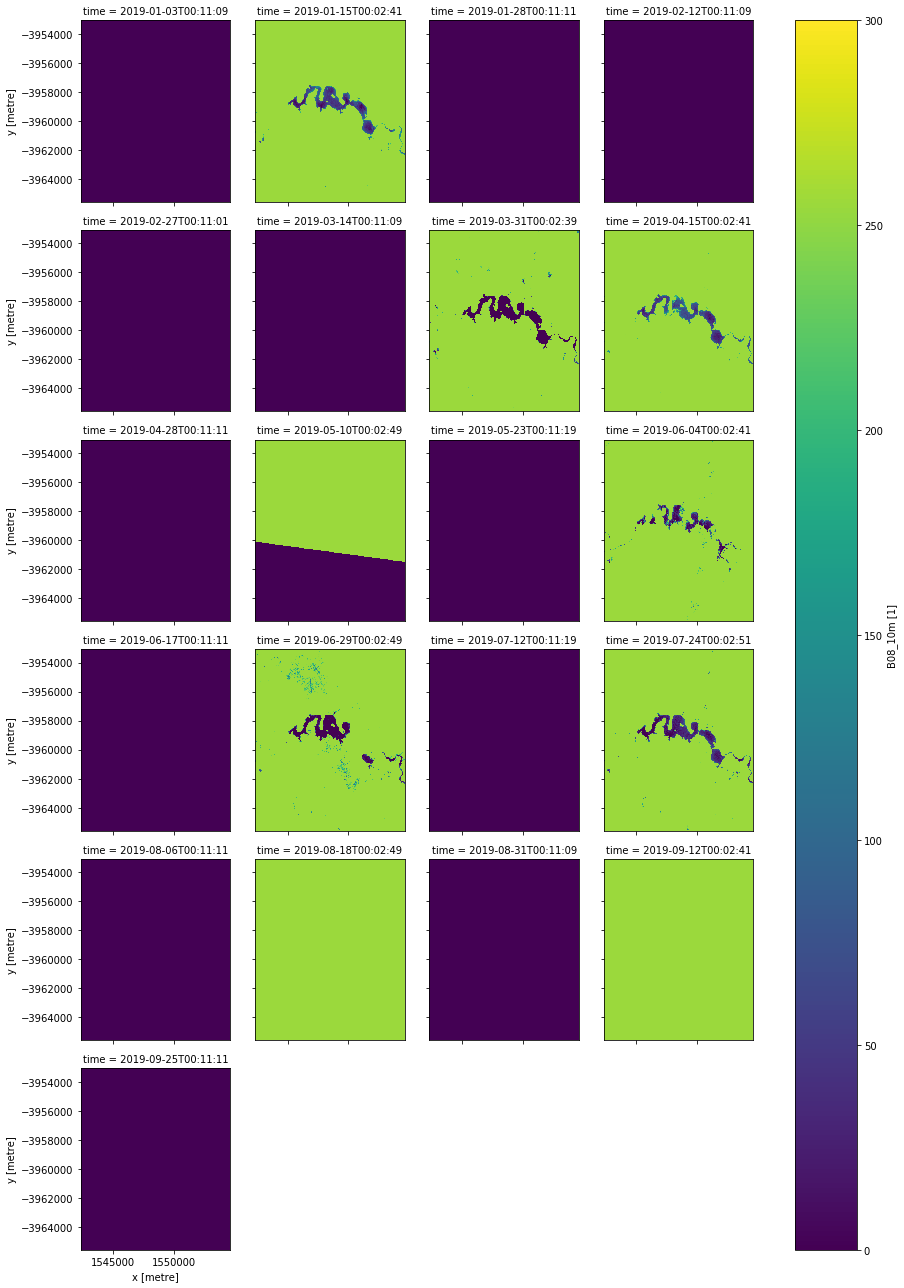

In [45]:
ntimes=len(s2_data.time.values)
s2_data.B08_10m.isel(time=slice(0,ntimes,5)).plot(col='time', col_wrap=4, vmin=0, vmax=300);

In [77]:
# Identify images that have minimum nulls and remove them
# Uses code from https://github.com/fangfy/dea-projects/blob/master/water_interoperability/sentinel1_load_and_classify_nci.ipynb

total_px=len(s2_data.x)*len(s2_data.y)
valid=s2_data.where(s2_data.B04_20m!=0).where(s2_data.SCL_20m<=7).where(s2_data.SCL_20m>=2).where(s2_data.SCL_20m!=3).count(dim=('x','y'))

good=(valid.B04_20m/total_px)>0.5

s2_good = s2_data.sel(time=good)
del s2_data

# replace 0 with nan
s2_good_clean = s2_good.where(s2_good!=0)
del s2_good

s2_good_clean

<xarray.Dataset>
Dimensions:  (time: 34, x: 422, y: 491)
Coordinates:
  * time     (time) datetime64[ns] 2019-01-15T00:02:41 ... 2019-09-27T00:02:39
  * y        (y) float64 -3.958e+06 -3.958e+06 ... -3.946e+06 -3.946e+06
  * x        (x) float64 1.581e+06 1.581e+06 1.581e+06 ... 1.571e+06 1.571e+06
Data variables:
    B04_20m  (time, y, x) float64 1.045e+03 1.105e+03 1.319e+03 ... 693.0 781.0
    B03_20m  (time, y, x) float64 1.018e+03 1.04e+03 1.141e+03 ... 659.0 751.0
    B02_20m  (time, y, x) float64 631.0 651.0 764.0 736.0 ... 448.0 477.0 518.0
    B08_10m  (time, y, x) float64 255.0 255.0 255.0 255.0 ... 255.0 255.0 255.0
    SCL_20m  (time, y, x) float64 4.0 4.0 4.0 4.0 4.0 ... 5.0 4.0 4.0 4.0 4.0
Attributes:
    crs:      EPSG: 3577

In [78]:
from datacube.storage import masking

# Set all nodata pixels to `NaN`:
s2_good_clean = masking.mask_invalid_data(s2_good_clean)
s2_good_clean = s2_good_clean.where((s2_good_clean >= 0) & (s2_good_clean<=4000))

# mask for clouds [0=no data, 1=saturated, 2=dark pixels, 3=cloud shadow, 4=veg, 5=soil, 
# 6=water, 7, 8, 9=clouds (low/med/high prob), 10=cirrus, 11= snow]
s2_good_clean = s2_good_clean.where((s2_good_clean.SCL_20m >= 2) & (s2_good_clean.SCL_20m <= 7))
s2_good_clean

<xarray.Dataset>
Dimensions:  (time: 34, x: 422, y: 491)
Coordinates:
  * time     (time) datetime64[ns] 2019-01-15T00:02:41 ... 2019-09-27T00:02:39
  * y        (y) float64 -3.958e+06 -3.958e+06 ... -3.946e+06 -3.946e+06
  * x        (x) float64 1.581e+06 1.581e+06 1.581e+06 ... 1.571e+06 1.571e+06
Data variables:
    B04_20m  (time, y, x) float64 1.045e+03 1.105e+03 1.319e+03 ... 693.0 781.0
    B03_20m  (time, y, x) float64 1.018e+03 1.04e+03 1.141e+03 ... 659.0 751.0
    B02_20m  (time, y, x) float64 631.0 651.0 764.0 736.0 ... 448.0 477.0 518.0
    B08_10m  (time, y, x) float64 255.0 255.0 255.0 255.0 ... 255.0 255.0 255.0
    SCL_20m  (time, y, x) float64 4.0 4.0 4.0 4.0 4.0 ... 5.0 4.0 4.0 4.0 4.0
Attributes:
    crs:      EPSG: 3577

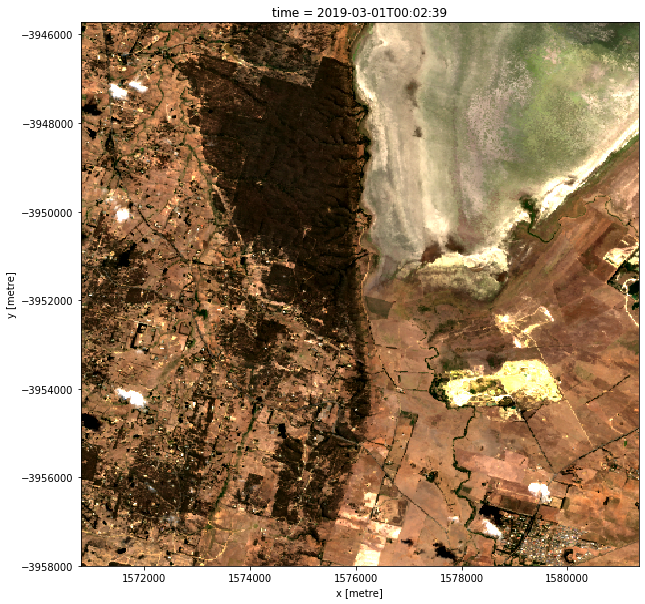

In [82]:
# Select a time slice from the EO data and combine the bands into a 3 band array
image_array = s2_good_clean[['B04_20m', 'B03_20m', 'B02_20m']].isel(time=6).to_array()

# Show the image
image_array.plot.imshow(robust=True, figsize=(10, 10));

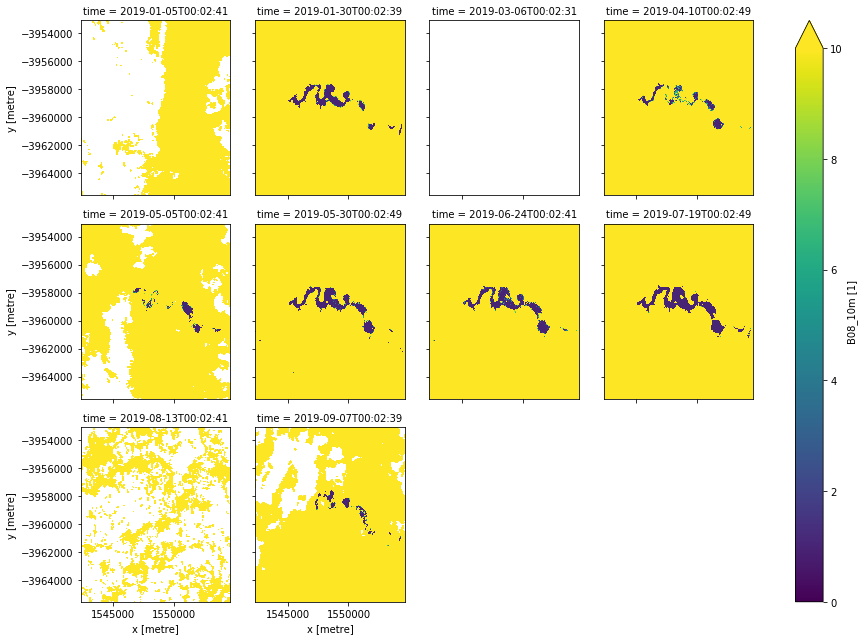

In [41]:
# View S2 NDVI time series
ntimes=len(s2_good_clean.time.values)
s2_good_clean.B08_10m.isel(time=slice(0,ntimes,5)).plot(col='time', col_wrap=4, vmin=0, vmax=10);

In [37]:
s2_good_clean.B08_10m

<xarray.DataArray 'B08_10m' (time: 50, y: 500, x: 492)>
array([[[255., 255., ..., 255., 255.],
        [255., 255., ..., 255., 255.],
        ...,
        [255., 255., ...,  nan,  nan],
        [255., 255., ...,  nan,  nan]],

       [[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ...,
        [255., 255., ...,  nan,  nan],
        [255., 255., ...,  nan,  nan]],

       ...,

       [[ nan,  nan, ..., 255., 255.],
        [ nan,  nan, ..., 255., 255.],
        ...,
        [255., 255., ..., 255., 255.],
        [255., 255., ..., 255., 255.]],

       [[255., 255., ..., 255., 255.],
        [255., 255., ..., 255., 255.],
        ...,
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]]])
Coordinates:
  * time     (time) datetime64[ns] 2019-01-05T00:02:41 ... 2019-09-27T00:02:39
  * y        (y) float64 -3.966e+06 -3.966e+06 ... -3.953e+06 -3.953e+06
  * x        (x) float64 1.555e+06 1.555e+06 1.555e+06 ... 1.542e+06 1.542e+06
Att

In [83]:
# Create NDVI band
s2_good_clean['ndvi']=(s2_good_clean.B08_10m.astype(float) - s2_good_clean.B04_20m.astype(float))/(s2_good_clean.B08_10m.astype(float) + s2_good_clean.B04_20m.astype(float))
# Remove any remaining erroneous values (where NDVI <-1.0 and NDVI > 1.0
S2_good_clean = s2_good_clean.where(s2_good_clean.ndvi > -1.0).where(s2_good_clean.ndvi < 1.0)
s2_good_clean

<xarray.Dataset>
Dimensions:  (time: 34, x: 422, y: 491)
Coordinates:
  * time     (time) datetime64[ns] 2019-01-15T00:02:41 ... 2019-09-27T00:02:39
  * y        (y) float64 -3.958e+06 -3.958e+06 ... -3.946e+06 -3.946e+06
  * x        (x) float64 1.581e+06 1.581e+06 1.581e+06 ... 1.571e+06 1.571e+06
Data variables:
    B04_20m  (time, y, x) float64 1.045e+03 1.105e+03 1.319e+03 ... 693.0 781.0
    B03_20m  (time, y, x) float64 1.018e+03 1.04e+03 1.141e+03 ... 659.0 751.0
    B02_20m  (time, y, x) float64 631.0 651.0 764.0 736.0 ... 448.0 477.0 518.0
    B08_10m  (time, y, x) float64 255.0 255.0 255.0 255.0 ... 255.0 255.0 255.0
    SCL_20m  (time, y, x) float64 4.0 4.0 4.0 4.0 4.0 ... 5.0 4.0 4.0 4.0 4.0
    ndvi     (time, y, x) float64 -0.6077 -0.625 -0.676 ... -0.462 -0.5077
Attributes:
    crs:      EPSG: 3577

In [ ]:
dc_S2 = datacube.Datacube(app='dc-S2-extract')

# Read S2 green, nir and cloud mask bands for S2a and S2b
bands_of_interest = ['nbar_green', 'nbar_nir_2', 'fmask']
sensors = ['s2a','s2b']

s2 = {}
for sensor in sensors:
    s2[sensor] = dc_S2.load(product = sensor+'_ard_granule', group_by='solar_day', measurements = bands_of_interest, **query)
    
# Combine the S2a and S2b dates
s2_clean = xr.concat(s2.values(), dim='time')

del s2

# Remove clouds and nulls from S2 data
nbar_green = s2_clean.nbar_green
s2_good=nbar_green.to_dataset(name='green')
s2_good['nir']=s2_clean.nbar_nir_2
s2_good['fmask']=s2_clean.fmask

s2_good_temp = s2_good.where(s2_good.fmask<2) # to remove cloud/shadow/nulls based on fmask
s2_good_clean = s2_good_temp.where(s2_good_temp.fmask!=0)

s2_good_clean = s2_good_clean.assign_attrs(bs_attrs)

del s2_good

# Create NDVI band
s2_good_clean['ndvi']=(s2_good_clean.nir.astype(float) - s2_good_clean.green.astype(float))/(s2_good_clean.nir.astype(float) + s2_good_clean.green.astype(float))

# Remove any remaining erroneous values (where NDVI <-1.0 and NDVI > 1.0)
s2_good_clean = s2_good_clean.where(s2_good_clean.ndvi > -1.0).where(s2_good_clean.ndvi < 1.0)
print('Sentinel-2 data for ', myloc,': ',s2_good_clean)

## View NDVI images

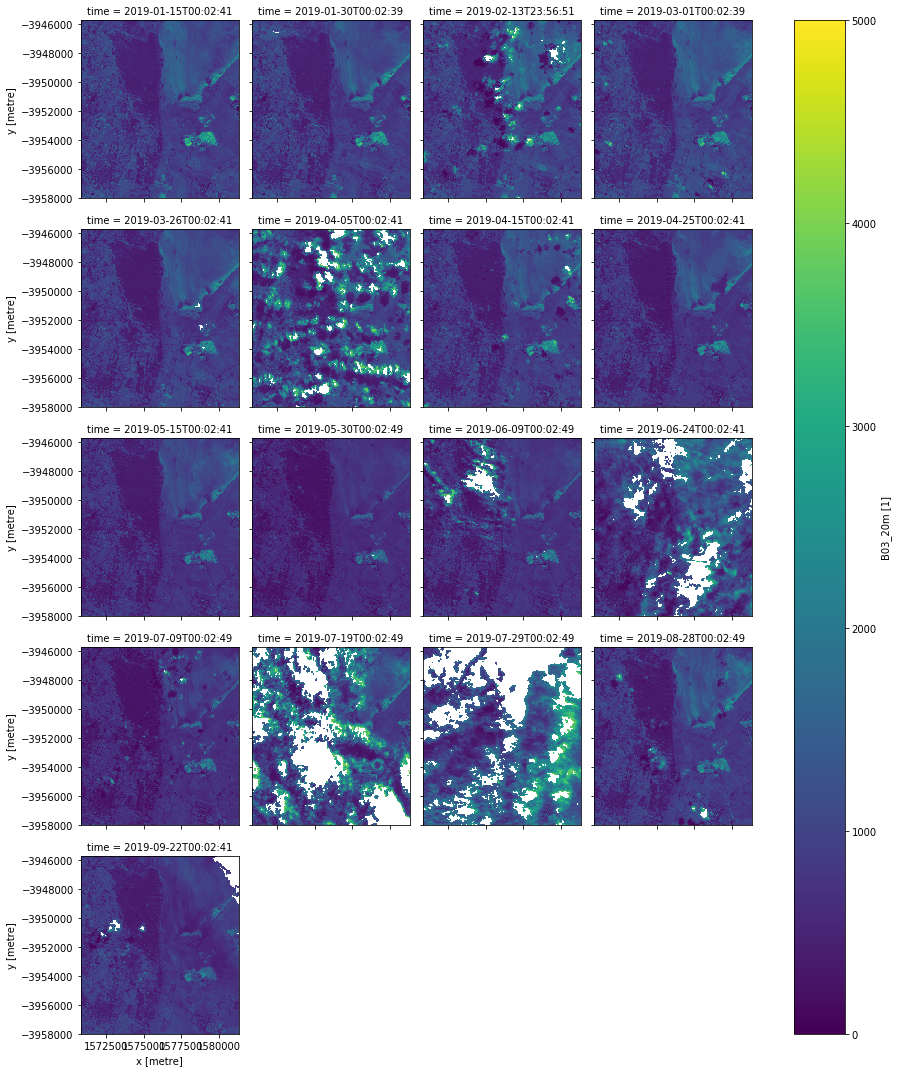

In [84]:
# View S2 NDVI time series
ntimes=len(s2_good_clean.time.values)
#s2_good_clean.isel(time=slice(0,ntimes,2)).ndvi.plot(col='time', col_wrap=4, vmin=-1.0, vmax=1.0);
s2_good_clean.isel(time=slice(0,ntimes,2)).B03_20m.plot(col='time', col_wrap=4, vmin=0, vmax=5000);

# Select area of interest to interactively to look at RVI, Entropy and NDVI time series

Click on the pixel to view its time series below


HTML(value='Click on the pixel to view its time series below')

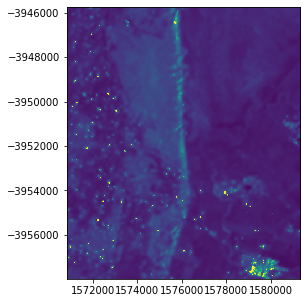

In [85]:
#%pylab notebook

#from IPython.display import display
warnings.filterwarnings('ignore')

def onclick(event):
    global pixelx, pixely
    x, y = int(event.xdata), int(event.ydata)
    image_coords = smoothed.affine * (x, y)
    pixelx = x 
    pixely = y 
    w.value = 'pixelx : {}, pixely : {}'.format(pixelx, pixely)
    print('data values:',x,y)

print('\033[1m' + 'Click on the pixel to view its time series below' + '\033[0m')

fig = plt.figure(figsize = (5,5))
plt.imshow(np.flip(smoothed.vv.mean(dim='time')), interpolation = 'nearest', clim=(0,0.5), extent=[smoothed.coords['x'].min(), smoothed.coords['x'].max(), smoothed.coords['y'].min(), smoothed.coords['y'].max()]); 

w = widgets.HTML("Click on the pixel to view its time series below")

cid = fig.canvas.mpl_connect('button_press_event', onclick)
display(w)

## Plot monthly time series based on selected pixel

In [87]:
# plot RVI, Entropy and NDVI through time based on the x,y point selected

import ipywidgets as widgets
from ipywidgets import interact, interact_manual, interactive
warnings.filterwarnings('ignore', module='datacube')

# expand selected x,y pixel to make a square area of interest
#pixelx, pixely = 1544000, -3956000 # Cenberra scene
pixelx, pixely = 1580000, -3956000 # Lake George

xp, yp=slice(pixelx+100,pixelx-100), slice(pixely-100,pixely+100)

@interact(myname=['monthly RVI','monthly Entropy'])

def plot(myname='monthly RVI'):
    global myplot, myimage, mytitle
    if myname == 'monthly RVI': 
        (smoothed.sel(x=xp,y=yp).RVI.groupby('time.month').mean()).plot(color='r', figsize=(5,3));
        myplot = (smoothed.sel(x=xp,y=yp).RVI.groupby('time').mean())
        myimage = smoothed.RVI
        mytitle = 'RVI (all images)'
    if myname == 'monthly Entropy': 
        (dp.sel(x=xp,y=yp).entropy.groupby('time.month').mean()).plot(color='b', figsize=(5,3));
        myplot = (dp.sel(x=xp,y=yp).entropy.groupby('time').mean())
        myimage = dp.entropy
        mytitle = 'Entropy (all images)'

    #(s2_good_clean.sel(x=xp,y=yp).ndvi.groupby('time.month').mean()).plot(color='g', figsize=(5,3));
    (s2_good_clean.sel(x=xp,y=yp).B03_20m.groupby('time.month').mean()).plot(color='g', figsize=(5,3));
        

interactive(children=(Dropdown(description='myname', options=('monthly RVI', 'monthly Entropy'), value='monthl…

## View time series of selected timeseries (RVI or Entropy) based on all scenes
### Select a point to view scene

<Figure size 432x288 with 0 Axes>

HTML(value='Click on the pixel to view its time series below')

Text(0.5, 1.0, 'RVI (all images)')

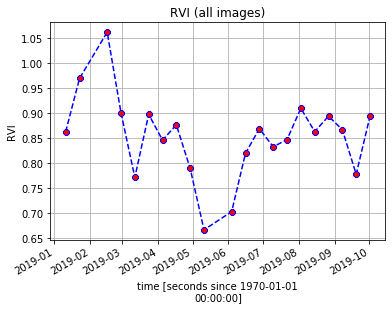

In [90]:
# Click on a point in the time-series from RVI or Entropy (selected above) to display the image

#Use this plot to visualise a time series and select the image that corresponds with a point in the time series
def callback(event):
    global time_int, devent
    devent = event
    time_int = event.xdata
    w.value = 'time_int: {}'.format(time_int)

fig = plt.figure(figsize=(6,4))

fig.canvas.mpl_connect('button_press_event', callback)
plt.show()
display(w)
myplot.plot(linestyle= '--', c= 'b', marker = '8', mec = 'b', mfc ='r');
plt.grid()
plt.title(mytitle)

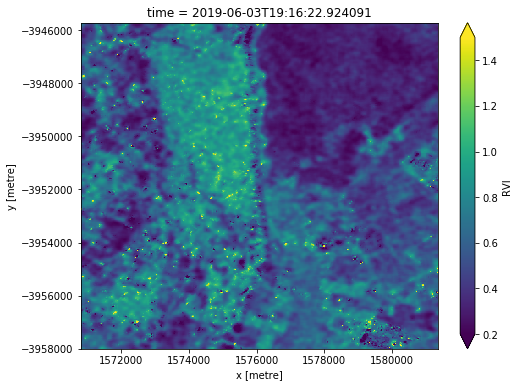

In [91]:
# Plot image from selected time slice

#time_slice = matplotlib.dates.num2date(time_int).date()
#myimage.sel(time=time_slice, method='nearest').plot(vmin=0.2, vmax=1.5, figsize=(8,6));
#plt.title(time_slice)

myimage.isel(time=10).plot(vmin=0.2, vmax=1.5, figsize=(8,6));

# Show Annual Statistics
## Annual difference in RVI, Entropy and NDVI

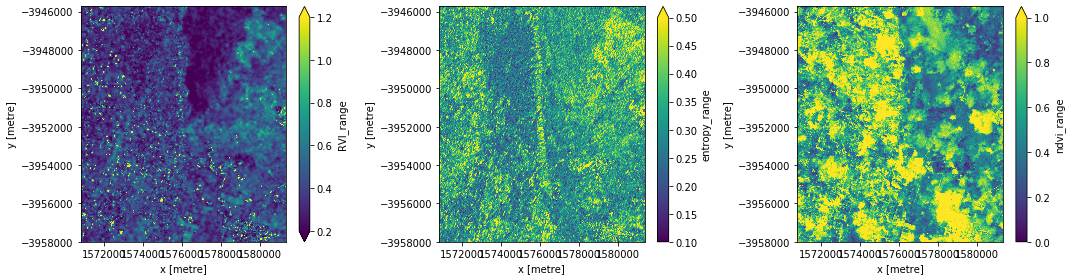

In [92]:
# Calculate annual range (max minus min) for radar backscatter RVI, dul-pol decomposition Entropy, and NDVI
from matplotlib import pyplot as plt
#pylab.rcParams['font.size']=7

smoothed['RVI_range'] = smoothed.RVI.max(dim='time') - smoothed.RVI.min(dim='time')
dp['entropy_range'] = dp.entropy.max(dim='time') - dp.entropy.min(dim='time')
s2_good_clean['ndvi_range'] = s2_good_clean.ndvi.max(dim='time') - s2_good_clean.ndvi.min(dim='time')

fix, axes = plt.subplots(ncols=3, figsize=(15,4))

smoothed.RVI_range.plot(vmin=0.2,vmax=1.2, ax=axes[0]);
dp.entropy_range.plot(vmin=0.1,vmax=0.5, ax=axes[1]);
s2_good_clean.ndvi_range.plot(vmin=0.0,vmax=1.0, ax=axes[2]);
plt.tight_layout()
plt.draw()

## Annual RVI, Entropy and NDVI mean, min, max and std

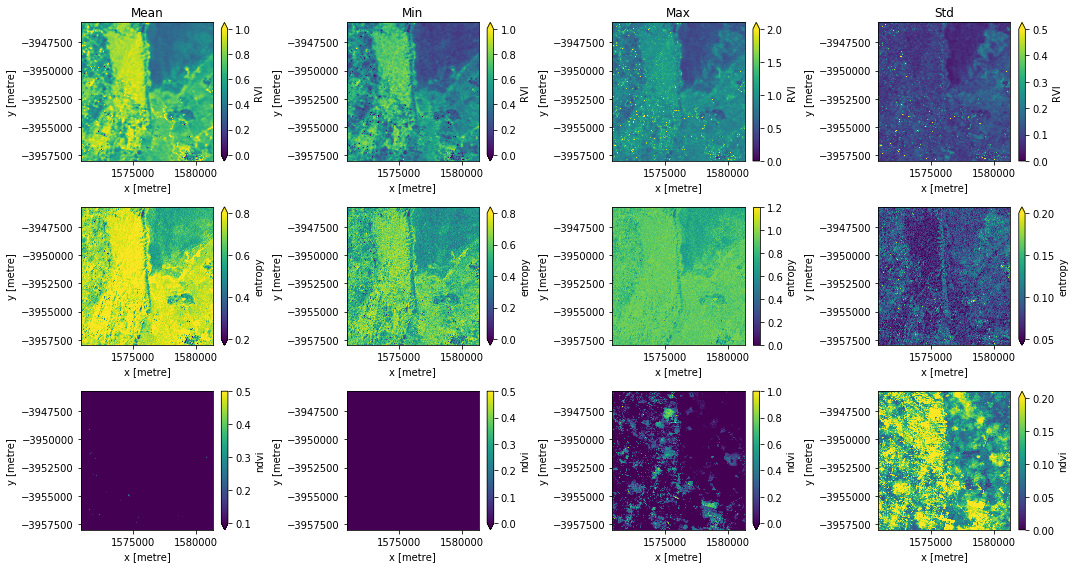

In [93]:
# Show RVI, Entropy and NDVI mean, min, max and stand deviation for current year

fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(15,8))

smoothed.RVI.mean(dim='time').plot(vmin=0.0,vmax=1.0, ax=axes[0,0]);
smoothed.RVI.min(dim='time').plot(vmin=0.0,vmax=1.0, ax=axes[0,1]);
smoothed.RVI.max(dim='time').plot(vmin=0.0,vmax=2.0, ax=axes[0,2]);
smoothed.RVI.std(dim='time').plot(vmin=0.0,vmax=0.5, ax=axes[0,3]);
dp.entropy.mean(dim='time').plot(vmin=0.2,vmax=0.8, ax=axes[1,0]);
dp.entropy.min(dim='time').plot(vmin=0.0,vmax=0.8, ax=axes[1,1]);
dp.entropy.max(dim='time').plot(vmin=0.0,vmax=1.2, ax=axes[1,2]);
dp.entropy.std(dim='time').plot(vmin=0.05,vmax=0.2, ax=axes[1,3]);
s2_good_clean.ndvi.mean(dim='time').plot(vmin=0.1,vmax=0.5, ax=axes[2,0]);
s2_good_clean.ndvi.min(dim='time').plot(vmin=0.0,vmax=0.5, ax=axes[2,1]);
s2_good_clean.ndvi.max(dim='time').plot(vmin=0.0,vmax=1.0, ax=axes[2,2]);
s2_good_clean.ndvi.std(dim='time').plot(vmin=0.0,vmax=0.2, ax=axes[2,3]);

axes[0,0].set_title('Mean')
axes[0,1].set_title('Min')
axes[0,2].set_title('Max')
axes[0,3].set_title('Std')
plt.tight_layout()
plt.draw()

## Calculate and view monthly mean RVI images

In [94]:
# plot RVI, Entropy and NDVI through time based on the x,y point selected
#%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact
from matplotlib import pyplot as plt

import pandas as pd
time = pd.to_datetime(['2019-01-01','2019-02-01','2019-03-01','2019-04-01','2019-05-01','2019-06-01',
                             '2019-07-01','2019-08-01','2019-09-01'])#,'2017-10-01','2017-11-01','2017-12-01'])

monthly_mean_RVI=xr.Dataset({'Jan':(smoothed.RVI.sel(time=slice('2019-01-01', '2019-01-31')).mean(dim='time')), 'time': time})
monthly_mean_RVI['Feb']=smoothed.RVI.sel(time=slice('2019-02-01', '2019-02-28')).mean(dim='time')
monthly_mean_RVI['Mar']=smoothed.RVI.sel(time=slice('2019-03-01', '2019-03-31')).mean(dim='time')
monthly_mean_RVI['Apr']=smoothed.RVI.sel(time=slice('2019-04-01', '2019-04-30')).mean(dim='time')
monthly_mean_RVI['May']=smoothed.RVI.sel(time=slice('2019-05-01', '2019-05-31')).mean(dim='time')
monthly_mean_RVI['Jun']=smoothed.RVI.sel(time=slice('2019-06-01', '2019-06-30')).mean(dim='time')
monthly_mean_RVI['Jul']=smoothed.RVI.sel(time=slice('2019-07-01', '2019-07-31')).mean(dim='time')
monthly_mean_RVI['Aug']=smoothed.RVI.sel(time=slice('2019-08-01', '2019-08-31')).mean(dim='time')
monthly_mean_RVI['Sep']=smoothed.RVI.sel(time=slice('2019-09-01', '2019-09-30')).mean(dim='time')
#monthly_mean_RVI['Oct']=smoothed.RVI.sel(time=slice('2017-10-01', '2017-10-31')).mean(dim='time')
#monthly_mean_RVI['Nov']=smoothed.RVI.sel(time=slice('2017-11-01', '2017-11-30')).mean(dim='time')
#monthly_mean_RVI['Dec']=smoothed.RVI.sel(time=slice('2017-12-01', '2017-12-31')).mean(dim='time')

#monthly_mean_RVI = monthly_mean_RVI.assign_attrs(bs_attrs)

fig = plt.figure()

@interact(month=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep'])#,'Oct','Nov','Dec'])

def plot(month='Jan'):
    if month == 'Jan': plt.imshow(np.flip(monthly_mean_RVI.Jan), clim=(0,1.0))
    if month == 'Feb': plt.imshow(np.flip(monthly_mean_RVI.Feb), clim=(0,1.0))
    if month == 'Mar': plt.imshow(np.flip(monthly_mean_RVI.Mar), clim=(0,1.0))
    if month == 'Apr': plt.imshow(np.flip(monthly_mean_RVI.Apr), clim=(0,1.0))
    if month == 'May': plt.imshow(np.flip(monthly_mean_RVI.May), clim=(0,1.0))
    if month == 'Jun': plt.imshow(np.flip(monthly_mean_RVI.Jun), clim=(0,1.0))
    if month == 'Jul': plt.imshow(np.flip(monthly_mean_RVI.Jul), clim=(0,1.0))
    if month == 'Aug': plt.imshow(np.flip(monthly_mean_RVI.Aug), clim=(0,1.0))
    if month == 'Sep': plt.imshow(np.flip(monthly_mean_RVI.Sep), clim=(0,1.0))
    #if month == 'Oct': plt.imshow(np.flip(monthly_mean_RVI.Oct), clim=(0,1.0))
    #if month == 'Nov': plt.imshow(np.flip(monthly_mean_RVI.Nov), clim=(0,1.0))
    #if month == 'Dec': plt.imshow(np.flip(monthly_mean_RVI.Dec), clim=(0,1.0))


<Figure size 432x288 with 0 Axes>

interactive(children=(Dropdown(description='month', options=('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', …

## Calculate and view monthly mean Entropy images

In [95]:
# Display a monthly mean
# plot RVI, Entropy and NDVI through time based on the x,y point selected
#%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact
from matplotlib import pyplot as plt

import pandas as pd
time = pd.to_datetime(['2019-01-01','2019-02-01','2019-03-01','2019-04-01','2019-05-01','2019-06-01',
                             '2019-07-01','2019-08-01','2019-09-01'])#,'2017-10-01','2017-11-01','2017-12-01'])

monthly_mean_entropy=xr.Dataset({'Jan':(dp.entropy.sel(time=slice('2019-01-01', '2019-01-31')).mean(dim='time')), 'time': time})
monthly_mean_entropy['Feb']=dp.entropy.sel(time=slice('2019-02-01', '2019-02-28')).mean(dim='time')
monthly_mean_entropy['Mar']=dp.entropy.sel(time=slice('2019-03-01', '2019-03-31')).mean(dim='time')
monthly_mean_entropy['Apr']=dp.entropy.sel(time=slice('2019-04-01', '2019-04-30')).mean(dim='time')
monthly_mean_entropy['May']=dp.entropy.sel(time=slice('2019-05-01', '2019-05-31')).mean(dim='time')
monthly_mean_entropy['Jun']=dp.entropy.sel(time=slice('2019-06-01', '2019-06-30')).mean(dim='time')
monthly_mean_entropy['Jul']=dp.entropy.sel(time=slice('2019-07-01', '2019-07-31')).mean(dim='time')
monthly_mean_entropy['Aug']=dp.entropy.sel(time=slice('2019-08-01', '2019-08-31')).mean(dim='time')
monthly_mean_entropy['Sep']=dp.entropy.sel(time=slice('2019-09-01', '2019-09-30')).mean(dim='time')
#monthly_mean_entropy['Oct']=dp.entropy.sel(time=slice('2017-10-01', '2017-10-31')).mean(dim='time')
#monthly_mean_entropy['Nov']=dp.entropy.sel(time=slice('2017-11-01', '2017-11-30')).mean(dim='time')
#monthly_mean_entropy['Dec']=dp.entropy.sel(time=slice('2017-12-01', '2017-12-31')).mean(dim='time')

fig = plt.figure()

@interact(month=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep'])#,'Oct','Nov','Dec'])

def plot(month='Jan'):
    if month == 'Jan': plt.imshow(np.flip(monthly_mean_entropy.Jan), clim=(0,1.0))
    if month == 'Feb': plt.imshow(np.flip(monthly_mean_entropy.Feb), clim=(0,1.0))
    if month == 'Mar': plt.imshow(np.flip(monthly_mean_entropy.Mar), clim=(0,1.0))
    if month == 'Apr': plt.imshow(np.flip(monthly_mean_entropy.Apr), clim=(0,1.0))
    if month == 'May': plt.imshow(np.flip(monthly_mean_entropy.May), clim=(0,1.0))
    if month == 'Jun': plt.imshow(np.flip(monthly_mean_entropy.Jun), clim=(0,1.0))
    if month == 'Jul': plt.imshow(np.flip(monthly_mean_entropy.Jul), clim=(0,1.0))
    if month == 'Aug': plt.imshow(np.flip(monthly_mean_entropy.Aug), clim=(0,1.0))
    if month == 'Sep': plt.imshow(np.flip(monthly_mean_entropy.Sep), clim=(0,1.0))
    #if month == 'Oct': plt.imshow(np.flip(monthly_mean_entropy.Oct), clim=(0,1.0))
    #if month == 'Nov': plt.imshow(np.flip(monthly_mean_entropy.Nov), clim=(0,1.0))
    #if month == 'Dec': plt.imshow(np.flip(monthly_mean_entropy.Dec), clim=(0,1.0))

<Figure size 432x288 with 0 Axes>

interactive(children=(Dropdown(description='month', options=('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', …

# Write output scenes to GeoTIFFs
## Output annual range and monthly mean RVI and Entropy images to GeoTIFF format

In [ ]:
@interact(myoutputdir=['/g/data/qd04/Cate/TempProcessing/','/g/data/qd04/Cate/'])

def plot(myoutputdir='/g/data/qd04/Cate/TempProcessing/'):
    global mydir
    if myoutputdir == '/g/data/qd04/Cate/TempProcessing/': mydir = '/g/data/qd04/Cate/TempProcessing/'
    if myoutputdir == '/g/data/qd04/Cate/':mydir = '/g/data/qd04/Cate/'

In [ ]:
@interact(myoutputfiles=['output files','stop'])

def plot(myoutputfiles='stop'):
    if myoutputfiles == 'output files': 
        print('Writing GeoTIFF files')
    
        # write output images (in Albers) to GeoTIFF

        import ogr, gdal, osr

        #mydir = '/g/data/qd04/Cate/TempProcessing/'

        # define coordinates for Albers equal area (3577)
        xcoords = smoothed.isel(time=1).vv.indexes['x']
        ycoords = smoothed.isel(time=1).vv.indexes['y']
        yt,xt = smoothed.isel(time=1).vv.shape
        MaxValX = xcoords.shape
        MaxValY = ycoords.shape

        # set geotransform and output projection
        xres = 25 
        yres = 25 
        geotransform = (xcoords[MaxValX[0]-1]-(xres*0.5), xres, 0, ycoords[MaxValY[0]-1]+(yres*0.5), 0, -yres) # offset by half the pixel size since it needs to be top-left pixel coord
        srs = osr.SpatialReference() 
        srs.ImportFromEPSG(3577)

        # loop through monthly images
        months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

        # Edit output filenames (filename_RVI and filename_entropy) and directory as required
        for month in months:

            filename_RVI = 'S1_RVI_3577_'+ month +'_'+ Year +'.tif' 
            S1_ds = gdal.GetDriverByName('GTiff').Create(mydir+filename_RVI, 
                                                           xt, yt, 1, gdal.GDT_Float32)
            S1_ds.SetGeoTransform(geotransform) # specify coordinates
            S1_ds.SetProjection(srs.ExportToWkt()) # export coords to file
            S1_ds.GetRasterBand(1).WriteArray(np.flip(monthly_mean_RVI[month]).data) # write band to raster
            S1_ds.FlushCache()  # write to file
            S1_ds = None # save and close

            filename_entropy = 'S1_Entropy_3577_'+ month + '_'+ Year + '.tif' 
            S1_ds = gdal.GetDriverByName('GTiff').Create(mydir+filename_entropy, 
                                                           xt, yt, 1, gdal.GDT_Float32)
            S1_ds.SetGeoTransform(geotransform) # specify coordinates
            S1_ds.SetProjection(srs.ExportToWkt()) # export coords to file
            S1_ds.GetRasterBand(1).WriteArray(np.flip(monthly_mean_entropy[month]).data) # write band to raster
            S1_ds.FlushCache()  # write to file
            S1_ds = None # save and close

        # Output annual RVI and Entropy range images
        filename_RVI = 'S1_RVI_3577_Annual_Range_' + Year +'.tif' 
        S1_ds = gdal.GetDriverByName('GTiff').Create(mydir+filename_RVI, 
                                                           xt, yt, 1, gdal.GDT_Float32)
        S1_ds.SetGeoTransform(geotransform) # specify coordinates
        S1_ds.SetProjection(srs.ExportToWkt()) # export coords to file
        S1_ds.GetRasterBand(1).WriteArray(np.flip(smoothed.RVI_range).data) # write band to raster
        S1_ds.FlushCache()  # write to file
        S1_ds = None # save and close

        # Output annual RVI and Entropy range images
        filename_entropy = 'S1_Entropy_3577_Annual_Range_' + Year + '.tif' 
        S1_ds = gdal.GetDriverByName('GTiff').Create(mydir+filename_entropy, 
                                                           xt, yt, 1, gdal.GDT_Float32)
        S1_ds.SetGeoTransform(geotransform) # specify coordinates
        S1_ds.SetProjection(srs.ExportToWkt()) # export coords to file
        S1_ds.GetRasterBand(1).WriteArray(np.flip(dp.entropy_range).data) # write band to raster
        S1_ds.FlushCache()  # write to file
        S1_ds = None # save and close

    if myoutputfiles == 'stop': print('Finished without writing GeoTIFF files')